In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Aesthetic settings
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",

    # Force Times New Roman everywhere
    "font.family": "serif",
    "font.serif": ["Times New Roman"],

    # Uniform font sizes
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,

    "axes.titlepad": 10,
})

palette = {
    "wind": "#6b7d91",
    "solar": "#b09b6b",
}

sns.set_palette([palette["wind"], palette["solar"]])

# Create output folder
os.makedirs("plots_pv_wind", exist_ok=True)

In [33]:
files = [
    "gen_hourly_MW_2022.csv",
    "gen_hourly_MW_2023.csv",
    "gen_hourly_MW_2024.csv"
]

df_list = []

for f in files:
    temp = pd.read_csv(f, parse_dates=["datetime"])
    df_list.append(temp)

df_raw = pd.concat(df_list, ignore_index=True)

df_raw.head()


,datetime,Area,Production Type,Generation (MW)
0,2022-01-01 00:00:00,BZN|ES,Biomass,526.0
1,2022-01-01 01:00:00,BZN|ES,Biomass,533.0
2,2022-01-01 02:00:00,BZN|ES,Biomass,524.0
3,2022-01-01 03:00:00,BZN|ES,Biomass,532.0
4,2022-01-01 04:00:00,BZN|ES,Biomass,528.0


In [34]:
# Normalize column names
df_raw.columns = df_raw.columns.str.strip().str.replace(" ", "_")

# Keep only Solar PV and Wind Onshore
df = df_raw[df_raw["Production_Type"].isin([
    "Solar",
    "Wind Onshore"
])].copy()

df["datetime"] = pd.to_datetime(df["datetime"])
df.sort_values("datetime", inplace=True)

df.head()

,datetime,Area,Production_Type,Generation_(MW)
131867,2022-01-01 00:00:00,BZN|ES,Solar,75.0
158144,2022-01-01 00:00:00,BZN|ES,Wind Onshore,6342.0
158145,2022-01-01 01:00:00,BZN|ES,Wind Onshore,6398.0
131868,2022-01-01 01:00:00,BZN|ES,Solar,75.0
131869,2022-01-01 02:00:00,BZN|ES,Solar,75.0


In [35]:
df_wide = df.pivot_table(
    index="datetime",
    columns="Production_Type",
    values="Generation_(MW)",
    aggfunc="mean"
)

df_wide = df_wide.asfreq("h")  # enforce hourly index
df_wide.head()

Production_Type,Solar,Wind Onshore
datetime,,
2022-01-01 00:00:00,75.0,6342.0
2022-01-01 01:00:00,75.0,6398.0
2022-01-01 02:00:00,75.0,6456.0
2022-01-01 03:00:00,75.0,6144.0
2022-01-01 04:00:00,75.0,5943.0


In [36]:
# Replace weird zeros / negatives if any (ENTSO-e sometimes has missing = 0)
df_wide = df_wide.replace(0, np.nan)

# Interpolate gaps < 6h, fill edges
df_wide = df_wide.interpolate(method="time", limit=6)
df_wide = df_wide.ffill().bfill()

# Convert hourly MW (power) to hourly GWh (energy per hour)
df_wide_gwh = df_wide / 1000.0

df_wide_gwh.head()

Production_Type,Solar,Wind Onshore
datetime,,
2022-01-01 00:00:00,0.075,6.342
2022-01-01 01:00:00,0.075,6.398
2022-01-01 02:00:00,0.075,6.456
2022-01-01 03:00:00,0.075,6.144
2022-01-01 04:00:00,0.075,5.943


In [37]:
df_wide_gwh["Solar"].to_csv("actual_PV_2022_2024.csv")
df_wide_gwh["Wind Onshore"].to_csv("actual_Wind_2022_2024.csv")

df_wide_gwh.head()

Production_Type,Solar,Wind Onshore
datetime,,
2022-01-01 00:00:00,0.075,6.342
2022-01-01 01:00:00,0.075,6.398
2022-01-01 02:00:00,0.075,6.456
2022-01-01 03:00:00,0.075,6.144
2022-01-01 04:00:00,0.075,5.943


In [38]:
daily = df_wide_gwh.resample("D").sum()
monthly = df_wide_gwh.resample("ME").sum()

daily.head(), monthly.head()

(Production_Type    Solar  Wind Onshore
 datetime                              
 2022-01-01       51.3530       136.072
 2022-01-02       45.7035       101.440
 2022-01-03       51.6940       149.396
 2022-01-04       27.7420       295.832
 2022-01-05       35.5020       281.815,
 Production_Type        Solar  Wind Onshore
 datetime                                  
 2022-01-31       1664.735500     5291.3850
 2022-02-28       1835.288545     4539.2500
 2022-03-31       1512.061500     6297.2545
 2022-04-30       2888.156000     5396.5850
 2022-05-31       3906.554600     4419.5476)

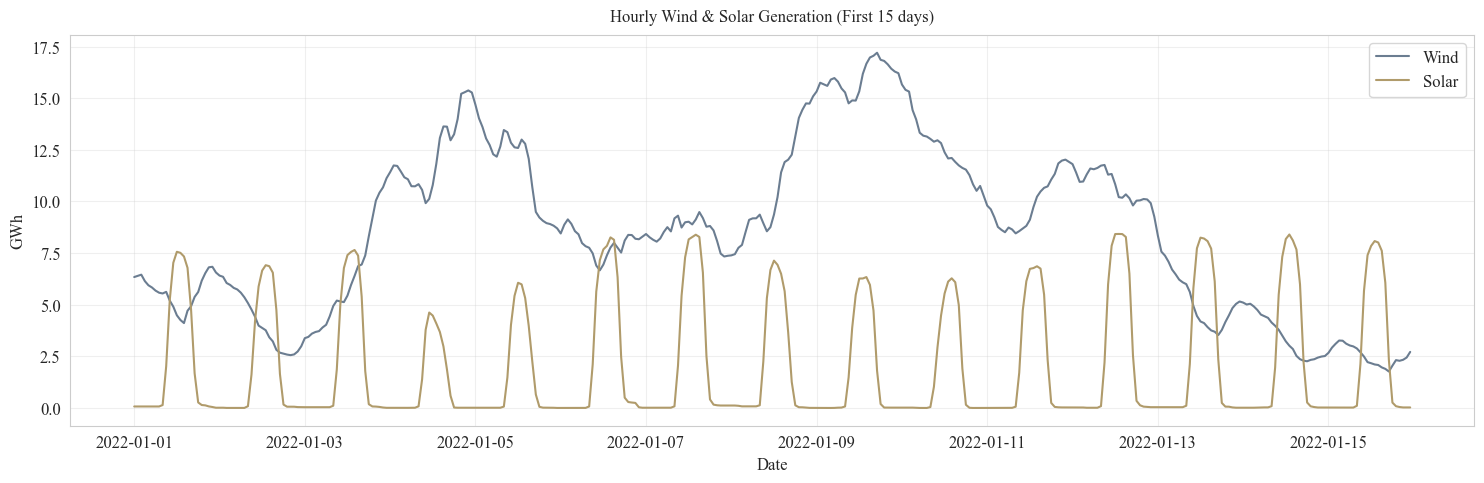

In [39]:
plt.figure(figsize=(15,5))
plt.plot(df_wide_gwh.index[:360], df_wide_gwh["Wind Onshore"][:360], label="Wind")
plt.plot(df_wide_gwh.index[:360], df_wide_gwh["Solar"][:360], label="Solar")
plt.title("Hourly Wind & Solar Generation (First 15 days)")
plt.ylabel("GWh")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots_pv_wind/hourly_sample.png", dpi=300)
plt.show()

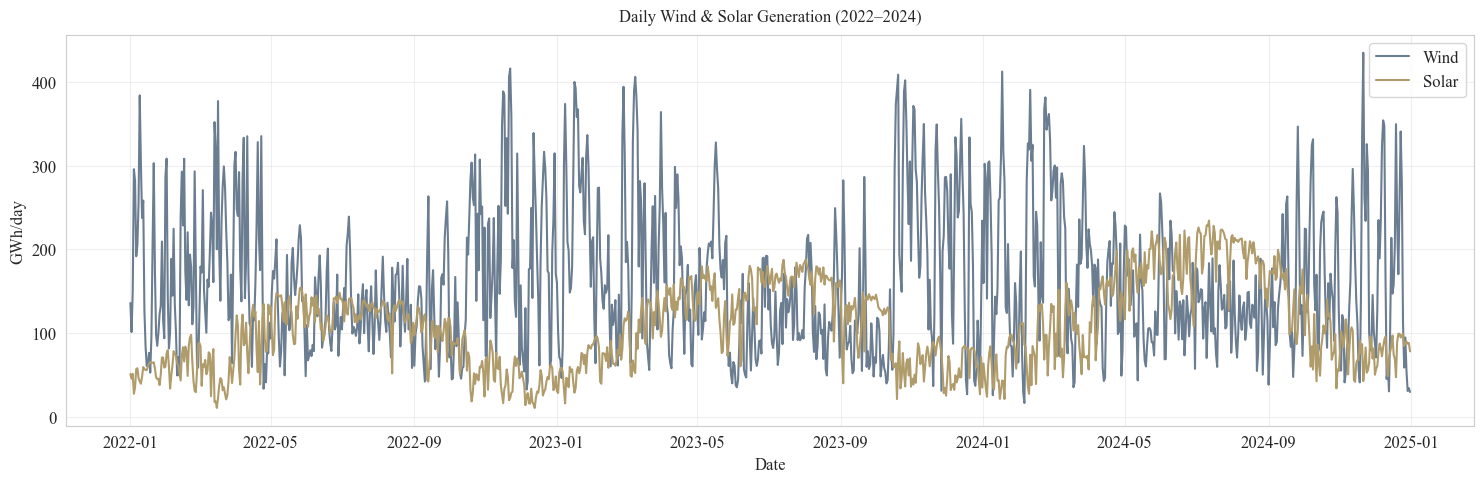

In [40]:
plt.figure(figsize=(15,5))
plt.plot(daily.index, daily["Wind Onshore"], label="Wind")
plt.plot(daily.index, daily["Solar"], label="Solar")
plt.title("Daily Wind & Solar Generation (2022–2024)")
plt.ylabel("GWh/day")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots_pv_wind/daily.png", dpi=300)
plt.show()

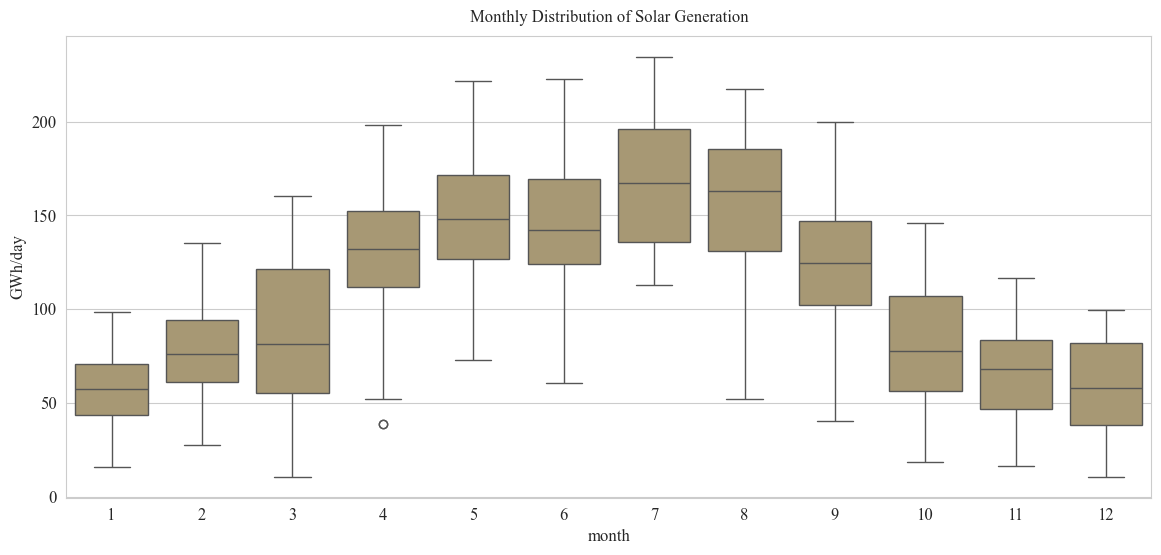

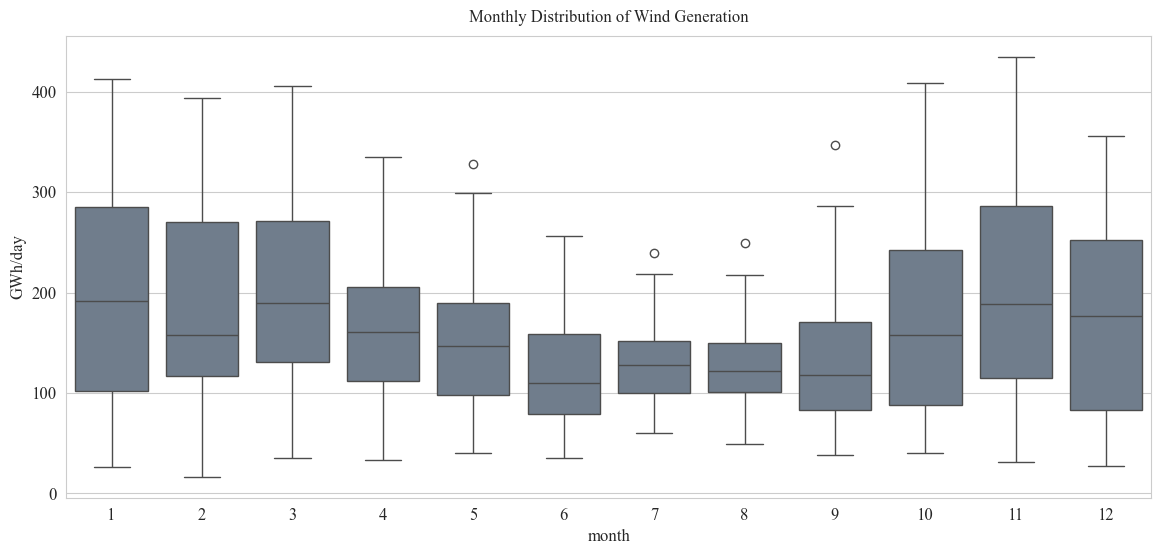

In [41]:
daily["month"] = daily.index.month

plt.figure(figsize=(14,6))
sns.boxplot(data=daily, x="month", y="Solar", color=palette["solar"])
plt.title("Monthly Distribution of Solar Generation")
plt.ylabel("GWh/day")
plt.savefig("plots_pv_wind/solar_monthly_box.png", dpi=300)
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=daily, x="month", y="Wind Onshore", color=palette["wind"])
plt.title("Monthly Distribution of Wind Generation")
plt.ylabel("GWh/day")
plt.savefig("plots_pv_wind/wind_monthly_box.png", dpi=300)
plt.show()

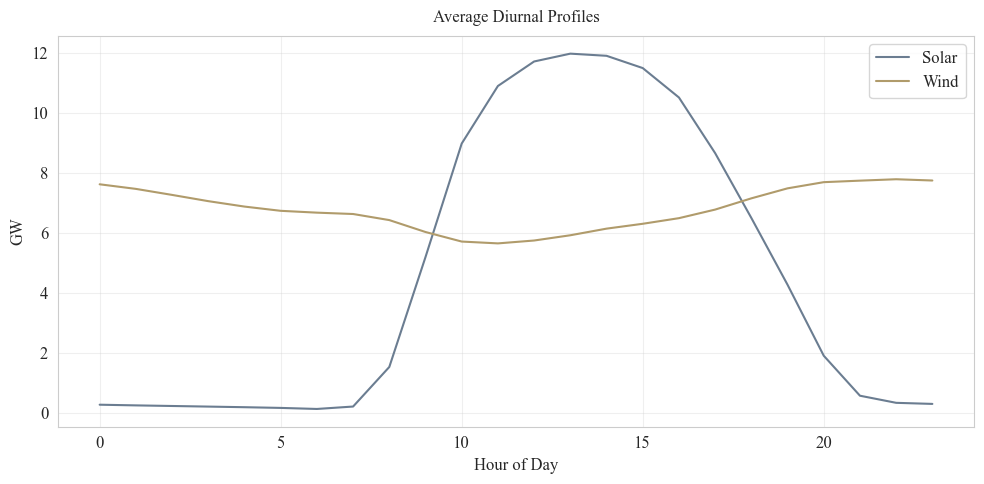

In [42]:
df_wide_gwh["hour"] = df_wide_gwh.index.hour

plt.figure(figsize=(10,5))
df_wide_gwh.groupby("hour")["Solar"].mean().plot(label="Solar")
df_wide_gwh.groupby("hour")["Wind Onshore"].mean().plot(label="Wind")
plt.title("Average Diurnal Profiles")
plt.ylabel("GW")
plt.xlabel("Hour of Day")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots_pv_wind/diurnal.png", dpi=300)
plt.show()

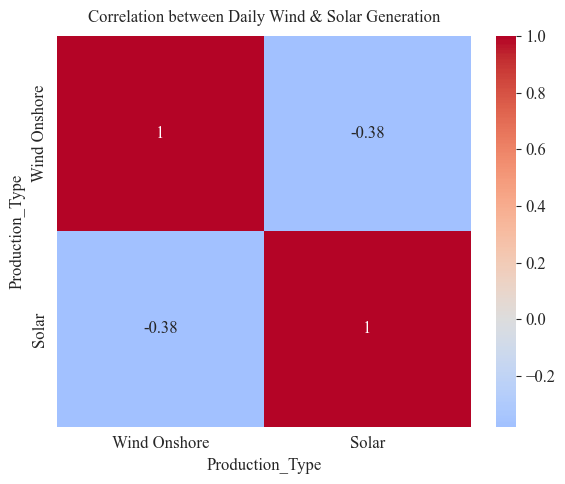

In [43]:
corr = daily[["Wind Onshore", "Solar"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Daily Wind & Solar Generation")
plt.tight_layout()
plt.savefig("plots_pv_wind/correlation.png", dpi=300)
plt.show()

In [44]:
# Load solar generation
df_solar_gen = pd.read_csv("actual_PV_2022_2024.csv", parse_dates=["datetime"])
df_solar_gen = df_solar_gen.rename(columns={"Solar": "Solar Generation"})
df_solar_gen = df_solar_gen.set_index("datetime").asfreq("h")

# Load wind generation
df_wind_gen = pd.read_csv("actual_Wind_2022_2024.csv", parse_dates=["datetime"])
df_wind_gen = df_wind_gen.rename(columns={"Wind_Onshore": "Wind Onshore"})
df_wind_gen = df_wind_gen.set_index("datetime").asfreq("h")

df_wind_gen.head(), df_solar_gen.head()


(                     Wind Onshore
 datetime                         
 2022-01-01 00:00:00         6.342
 2022-01-01 01:00:00         6.398
 2022-01-01 02:00:00         6.456
 2022-01-01 03:00:00         6.144
 2022-01-01 04:00:00         5.943,
                      Solar Generation
 datetime                             
 2022-01-01 00:00:00             0.075
 2022-01-01 01:00:00             0.075
 2022-01-01 02:00:00             0.075
 2022-01-01 03:00:00             0.075
 2022-01-01 04:00:00             0.075)

In [45]:
# Load wind features from Open-Meteo
wind_feat = pd.read_csv("Wind_2022_2024_raw.csv", parse_dates=["time"])
wind_feat = wind_feat.rename(columns={"time": "datetime"})
wind_feat = wind_feat.set_index("datetime").asfreq("h")

wind_feat.head()

,temperature_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,weather_code,precipitation,cloud_cover
datetime,,,,,,,
2022-01-01 00:00:00,4.3,1.7,7.9,15.5,0,0.0,1
2022-01-01 01:00:00,3.8,0.9,8.3,16.5,0,0.0,8
2022-01-01 02:00:00,3.5,0.6,8.4,17.0,0,0.0,4
2022-01-01 03:00:00,3.0,0.1,8.0,17.2,0,0.0,5
2022-01-01 04:00:00,1.9,-0.9,6.4,16.1,0,0.0,3


In [46]:
wind_full = df_wind_gen.merge(
    wind_feat,
    left_index=True,
    right_index=True,
    how="inner"
)

wind_full = wind_full.replace(0, np.nan)
wind_full = wind_full.interpolate(method="time", limit=6)
wind_full = wind_full.ffill().bfill()

wind_full.head()

,Wind Onshore,temperature_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,weather_code,precipitation,cloud_cover
datetime,,,,,,,,
2022-01-01 00:00:00,6.342,4.3,1.7,7.9,15.5,3.0,0.1,1.0
2022-01-01 01:00:00,6.398,3.8,0.9,8.3,16.5,3.0,0.1,8.0
2022-01-01 02:00:00,6.456,3.5,0.6,8.4,17.0,3.0,0.1,4.0
2022-01-01 03:00:00,6.144,3.0,0.1,8.0,17.2,3.0,0.1,5.0
2022-01-01 04:00:00,5.943,1.9,-0.9,6.4,16.1,3.0,0.1,3.0


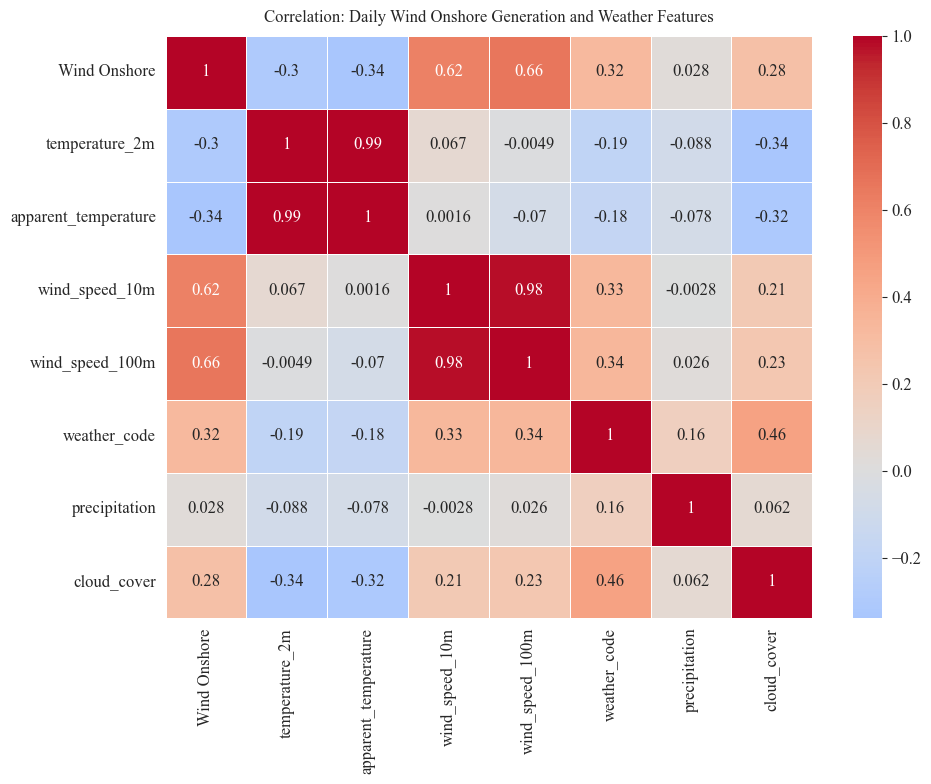

,Wind Onshore,temperature_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,weather_code,precipitation,cloud_cover
Wind Onshore,1.00,-0.30,-0.34,0.62,0.66,0.32,0.03,0.28
temperature_2m,-0.30,1.00,0.99,0.07,-0.00,-0.19,-0.09,-0.34
apparent_temperature,-0.34,0.99,1.00,0.00,-0.07,-0.18,-0.08,-0.32
wind_speed_10m,0.62,0.07,0.00,1.00,0.98,0.33,-0.00,0.21
wind_speed_100m,0.66,-0.00,-0.07,0.98,1.00,0.34,0.03,0.23
weather_code,0.32,-0.19,-0.18,0.33,0.34,1.00,0.16,0.46
precipitation,0.03,-0.09,-0.08,-0.00,0.03,0.16,1.00,0.06
cloud_cover,0.28,-0.34,-0.32,0.21,0.23,0.46,0.06,1.00


In [47]:
wind_daily = wind_full.resample("D").mean()

corr_wind = wind_daily.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_wind,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation: Daily Wind Onshore Generation and Weather Features")
plt.tight_layout()
plt.savefig("plots_pv_wind/corr_wind_features_daily.png", dpi=300)
plt.show()
corr_wind.round(2)

In [48]:
solar_feat = pd.read_csv("cleaned_solar_data.csv", parse_dates=["time"])
solar_feat = solar_feat.rename(columns={"time": "datetime"})

# Sort by time just to be tidy
solar_feat = solar_feat.sort_values("datetime")

# Aggregate any duplicate timestamps (mean is usually fine for meteo variables)
solar_feat = solar_feat.groupby("datetime", as_index=True).mean()

# Now the index is unique, we can safely enforce hourly frequency
solar_feat = solar_feat.asfreq("h")   # or "1H"

# Drop wind_speed_10m as requested
solar_feat = solar_feat.drop(columns=["wind_speed_10m"], errors="ignore")

solar_feat.head()

,irradiance,sun_height_angle,air_temperature
datetime,,,
2022-01-01 00:00:00,0.0,0.0,3.66
2022-01-01 01:00:00,0.0,0.0,3.11
2022-01-01 02:00:00,0.0,0.0,2.77
2022-01-01 03:00:00,0.0,0.0,2.52
2022-01-01 04:00:00,0.0,0.0,2.25


In [49]:
solar_full = df_solar_gen.merge(
    solar_feat,
    left_index=True,
    right_index=True,
    how="inner"
)

solar_full = solar_full.replace(0, np.nan)
solar_full = solar_full.interpolate(method="time", limit=6)
solar_full = solar_full.ffill().bfill()

solar_full.head()

,Solar Generation,irradiance,sun_height_angle,air_temperature
datetime,,,,
2022-01-01 00:00:00,0.075,301.17,4.31,3.66
2022-01-01 01:00:00,0.075,301.17,4.31,3.11
2022-01-01 02:00:00,0.075,301.17,4.31,2.77
2022-01-01 03:00:00,0.075,301.17,4.31,2.52
2022-01-01 04:00:00,0.075,301.17,4.31,2.25


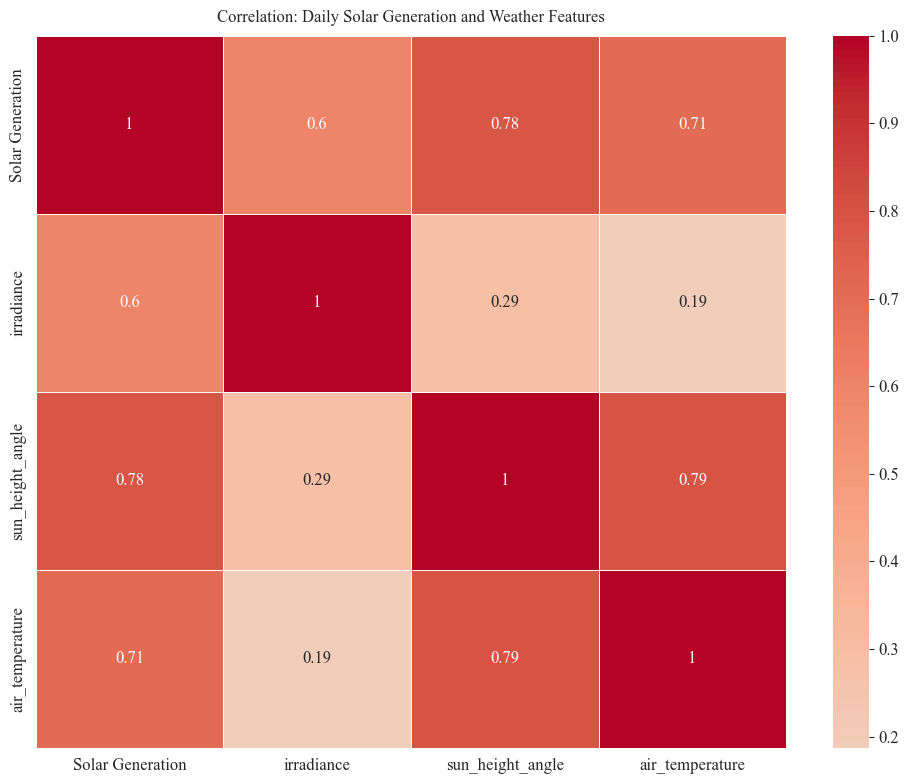

,Solar Generation,irradiance,sun_height_angle,air_temperature
Solar Generation,1.00,0.60,0.78,0.71
irradiance,0.60,1.00,0.29,0.19
sun_height_angle,0.78,0.29,1.00,0.79
air_temperature,0.71,0.19,0.79,1.00


In [50]:
solar_daily = solar_full.resample("D").mean()

corr_solar = solar_daily.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_solar,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation: Daily Solar Generation and Weather Features")
plt.tight_layout()
plt.savefig("plots_pv_wind/corr_solar_features_daily.png", dpi=300)
plt.show()

corr_solar.round(2)

In [51]:
os.makedirs("datasets_final", exist_ok=True)

wind_full.to_csv("datasets_final/wind_onshore_with_features_hourly_2022_2024.csv")
solar_full.to_csv("datasets_final/solar_with_features_hourly_2022_2023.csv")

print("Saved hourly wind + solar feature datasets.")

Saved hourly wind + solar feature datasets.
